# Imports, Custom Functions & Data Loading

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import spacy 

from collections import Counter, defaultdict
from transformers import AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from tqdm import tqdm

from sklearn.metrics import f1_score

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

# Ignore RuntimeWarning and UserWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Define functions

In [48]:
def preprocess(text):
    
    # remove URLs
    text = re.sub('http\S*', ' ', text)
    
    # remove non-alphabetic
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # make lowercase
    text = text.lower()

    # remove one character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    
    # replace double space to one space
    text = re.sub("\s+", ' ', text)
    
    # tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


class BPE():
    """Byte-Pair Encoding: Subword-based tokenization algorithm."""
    
    def __init__(self, corpus, vocab_size):
        """Initialize BPE tokenizer."""
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # pre-tokenize the corpus into words, BERT pre-tokenizer is used here
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        """Train BPE tokenizer."""
    # (1) Compute the frequencies of each word in the corpus
    # (2) Compute the base vocabulary of all characters in the corpus
    # (3) Split each word into individual characters before training
    # (4) Merge the most frequent pair iteratively until the vocabulary size is reached

        # compute the frequencies of each word in the corpus
        for text in self.corpus:
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        # compute the base vocabulary of all characters in the corpus
        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # add the special token </w> at the beginning of the vocabulary
        vocab = ["</w>"] + alphabet.copy()

        # split each word into individual characters before training
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # merge the most frequent pair iteratively until the vocabulary size is reached
        while len(vocab) < self.vocab_size:

            # compute the frequency of each pair
            pair_freqs = self.compute_pair_freqs()

            # find the most frequent pair
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # merge the most frequent pair
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """Compute the frequency of each pair."""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """Merge the given pair."""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):
        """Tokenize a given text with trained BPE tokenizer (including pre-tokenization, split, and merge)."""
        
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result
    

def get_tfidf_matrix(df, vectorizer):
    
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()

    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


# The sequences being in the formar ['word1', 'word2', 'word3', ...], preprocess it
def string2embedding_idx(text_sequence, model):

    sequence = []
    for token in text_sequence:
        try:
            sequence.append(model.wv.key_to_index[token])
        except:
            sequence.append(2899)

    return sequence


def TSNE_10ClosestWords(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0, perplexity = 10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    

class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sequence_tensor, label_tensor


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (output > 0.5).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, (data, target) in pbar:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = loss_fn(output, target)

                test_loss += loss.item()

                predicted = (output > 0.5).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst

# LSTM model with pre-trained Word2Vec embeddings
class CustomLSTM(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output


# GRU model with pre-trained Word2Vec embeddings
class CustomGRU(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output
    

# GRU model with pre-trained Word2Vec embeddings and attention mechanism
class CustomGRU_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output


# LSTM model with pre-trained Word2Vec embeddings and attention mechanism
class CustomLSTM_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output
    

# LSTM model with pre-trained Word2Vec embeddings and multi-head attention mechanism
class CustomLSTM_MultiHeadAttention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, dropout=0.1, num_layers=1, bidirectional=False, freeze_embeddings=True, num_heads=8):
        super(CustomLSTM_MultiHeadAttention, self).__init__()

        # Word embedding layer
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=freeze_embeddings)

        # LSTM layer
        self.sequence_size = 50
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Multi-Head Attention layer
        self.multihead_attention = torch.nn.MultiheadAttention(embed_dim=hidden_size * (2 if bidirectional else 1), num_heads=num_heads, dropout=dropout, batch_first=True)

        # Fully-connected layers for classification head
        self.fc1 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1) * self.sequence_size, hidden_size * (2 if bidirectional else 1))
        self.fc2 = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.bn = torch.nn.BatchNorm1d(hidden_size * (2 if bidirectional else 1))
        self.classification_head = torch.nn.Sequential(self.fc1, self.leaky_relu, self.bn, self.fc2)

        # Initialize the weights with the kaiming uniform initialization
        for layer in self.classification_head:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity = 'leaky_relu')

        # Initialize the weights with the kaiming uniform initialization for the multi-head attention
        torch.nn.init.kaiming_uniform_(self.multihead_attention.in_proj_weight, nonlinearity = 'leaky_relu')

        # Initialize the weights with the kaiming uniform initialization for the LSTM
        for layer in self.lstm._all_weights:
            for param_name in layer:
                if 'weight' in param_name:
                    torch.nn.init.kaiming_uniform_(getattr(self.lstm, param_name), nonlinearity = 'leaky_relu')


    def forward(self, x):
        # Get the embedding of each token in the sequence
        embed = self.embedding(x)
        # Apply LSTM to the sequence of embeddings
        hx, cx = self.lstm(embed)
        # Apply multihead attention and get attention weights
        attn_output, attn_weights = self.multihead_attention(hx, hx, hx)
        # Flatten or pool the multihead attention outputs across the sequence dimension
        flattened_output = attn_output.reshape(attn_output.size(0), -1)
        # Compute the logits considering the weighted values (V) of the multihead attention
        logits = self.classification_head(flattened_output)

        return logits


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.positional_encoding = torch.zeros((1, max_len, d_model))
        self.positional_encoding[0, :, 0::2] = torch.sin(position * div_term)
        self.positional_encoding[0, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1), :]


class TransformerEncoder(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True):
        super(TransformerEncoder, self).__init__()

        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_len)
        
        self.transformer_encoder_layer = torch.nn.TransformerEncoderLayer(
                                                                          d_model=embedding_dim,
                                                                          nhead=num_heads,
                                                                          dim_feedforward=hidden_dim,
                                                                          dropout=dropout
                                                                          )
        self.transformer_encoder = torch.nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)  # Change from (batch_size, seq_len, embedding_dim) to (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embedding_dim)
        return x
    

class TransformerEncoderForClassification(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True, num_classes=1):
        super(TransformerEncoderForClassification, self).__init__()

        self.embedding_dim = embedding_dim
        self.encoder = TransformerEncoder(word2vec_model, num_heads, hidden_dim, num_layers, max_len, dropout, freeze_embeddings)
        
        # Classification head
        self.fc = torch.nn.Linear(self.embedding_dim, num_classes)

    def forward(self, x):
        encoder_output = self.encoder(x)
        
        # Global average pooling along the sequence dimension
        pooled_output = torch.nn.functional.adaptive_avg_pool1d(encoder_output.permute(0, 2, 1), 1).squeeze(-1)
        
        # Classification head
        logits = self.fc(pooled_output)

        return logits
    

# FCNN model to be used with the TF-IDF features
class CustomFCNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomFCNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Data Loading

In [3]:
tweets_train = pd.read_csv('../data/tweets_data/train.csv')[['text', 'target']].reset_index(drop=True)
tweets_test = pd.read_csv('../data/tweets_data/test.csv')[['id', 'text']]
tweets_labels = pd.read_csv('../data/tweets_data/test_labels.csv', encoding='latin-1')[['choose_one', 'text']]

tweets_labels['target'] = (tweets_labels['choose_one']=='Relevant').astype(int)
tweets_labels['id'] = tweets_labels.index

tweets_test = pd.merge(left = tweets_test, right = tweets_labels, on='id', how = 'left')[['id', 'text_x', 'target']]
tweets_test.rename(columns={'text_x': 'text'}, inplace=True)
tweets_test = tweets_test[['text', 'target']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text,target
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


# Text pre-processing

## Cleaning text using key-words and lemmatization

In [4]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [5]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...



Testing data


,text,target,clean_text
0,Just happened a terrible car crash,1,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [6]:
# set the hyperparameter of vocabulary size
vocab_size = 3000
corpus = tweets_train['clean_text'].tolist()

# create a BPE tokenizer object
MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

# train BPE tokenizer with Wikipedia corpus
MyBPE.train()

{('e', 'r'): 'er',
 ('r', 'e'): 're',
 ('i', 'n'): 'in',
 ('a', 'n'): 'an',
 ('o', 'n'): 'on',
 ('s', 't'): 'st',
 ('a', 't'): 'at',
 ('a', 'r'): 'ar',
 ('a', 'l'): 'al',
 ('o', 'r'): 'or',
 ('e', 'n'): 'en',
 ('l', 'e'): 'le',
 ('l', 'i'): 'li',
 ('d', 'e'): 'de',
 ('i', 'c'): 'ic',
 ('s', 'e'): 'se',
 ('a', 'm'): 'am',
 ('r', 'o'): 'ro',
 ('l', 'o'): 'lo',
 ('i', 'l'): 'il',
 ('a', 'c'): 'ac',
 ('i', 't'): 'it',
 ('s', 'h'): 'sh',
 ('u', 'n'): 'un',
 ('c', 'h'): 'ch',
 ('c', 'o'): 'co',
 ('u', 'r'): 'ur',
 ('v', 'e'): 've',
 ('t', 'h'): 'th',
 ('r', 'a'): 'ra',
 ('i', 'on'): 'ion',
 ('g', 'e'): 'ge',
 ('i', 's'): 'is',
 ('m', 'e'): 'me',
 ('in', 'g'): 'ing',
 ('a', 'y'): 'ay',
 ('k', 'e'): 'ke',
 ('n', 'e'): 'ne',
 ('a', 'd'): 'ad',
 ('r', 'i'): 'ri',
 ('h', 'o'): 'ho',
 ('o', 'd'): 'od',
 ('s', 's'): 'ss',
 ('at', 'e'): 'ate',
 ('en', 't'): 'ent',
 ('e', 'l'): 'el',
 ('a', 'p'): 'ap',
 ('f', 'i'): 'fi',
 ('l', 'y'): 'ly',
 ('t', 'er'): 'ter',
 ('o', 'm'): 'om',
 ('g', 'h'): 'gh',
 (

In [7]:
tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))
tweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))

In [8]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild..."



Testing data


,text,target,clean_text,tokenized_text
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, ter, rible, car, crash]"
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]"
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]"
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


## Convert Text into Input Features

### TF-IDF

In [9]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(tweets_train['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

X_test = vectorizer.transform(tweets_test['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [10]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,target,clean_text,tokenized_text,TFIDF
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, ter, rible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [11]:
print('Maximum length of tokenized text in training data:', max([len(sent) for sent in tweets_train['tokenized_text']]))
print('Maximum length of tokenized text in testing data:', max([len(sent) for sent in tweets_test['tokenized_text']]))

Maximum length of tokenized text in training data: 42
Maximum length of tokenized text in testing data: 50


In [12]:
# Train Word2Vec model
cbow_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 512, window = 10, min_count = 1, workers = 4, sg = 0, epochs = 128)
# Add the <pad> token to the cbow_model so that the last token is the <pad> token
cbow_model.wv.key_to_index['<pad>'] = len(cbow_model.wv)
# Add the embedding of <pad> token to the cbow_model
cbow_model.wv.vectors = np.append(cbow_model.wv.vectors, np.zeros((1, 512)), axis=0)


skipgram_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 512, window = 10, min_count = 1, workers = 4, sg = 1, epochs = 128)
# Add the <pad> token to the skipgram_model so that the last token is the <pad> token
skipgram_model.wv.key_to_index['<pad>'] = len(skipgram_model.wv)
# Add the embedding of <pad> token to the skipgram_model
skipgram_model.wv.vectors = np.append(skipgram_model.wv.vectors, np.zeros((1, 512)), axis=0)

# Add the <pad> token to all the tokenized text until the length of each tokenized text is 50
tweets_train['tokenized_text'] = tweets_train['tokenized_text'].apply(lambda tokens: tokens + ['<pad>'] * (50 - len(tokens)))
tweets_test['tokenized_text'] = tweets_test['tokenized_text'].apply(lambda tokens: tokens + ['<pad>'] * (50 - len(tokens)))

# Apply the string2embedding_idx function to create a new column
tweets_train['CBOW_sequences'] = tweets_train['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_train['SkipGram_sequences'] = tweets_train['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))
tweets_test['CBOW_sequences'] = tweets_test['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_test['SkipGram_sequences'] = tweets_test['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))

In [13]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF,CBOW_sequences,SkipGram_sequences
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[31, 62, 850, 432, 2265, 425, 452, 2899, 2899,...","[31, 62, 850, 432, 2265, 425, 452, 2899, 2899,..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, cana...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[306, 16, 398, 75, 676, 128, 0, 616, 1619, 289...","[306, 16, 398, 75, 676, 128, 0, 616, 1619, 289..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1717, 616, 1709, 106, 664, 224, 2482, 671, 43...","[1717, 616, 1709, 106, 664, 224, 2482, 671, 43..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[55, 7, 115, 351, 236, 439, 451, 135, 2899, 28...","[55, 7, 115, 351, 236, 439, 451, 135, 2899, 28..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[545, 445, 266, 420, 652, 2464, 446, 236, 180,...","[545, 445, 266, 420, 652, 2464, 446, 236, 180,..."



Testing data


,text,target,clean_text,tokenized_text,TFIDF,CBOW_sequences,SkipGram_sequences
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, ter, rible, car, crash, <pad>, <pad>,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[416, 106, 2577, 74, 76, 2899, 2899, 2899, 289...","[416, 106, 2577, 74, 76, 2899, 2899, 2899, 289..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[257, 432, 1651, 235, 747, 1189, 2899, 2899, 2...","[257, 432, 1651, 235, 747, 1189, 2899, 2899, 2..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[306, 16, 962, 12, 1500, 29, 2831, 1162, 8, 76...","[306, 16, 962, 12, 1500, 29, 2831, 1162, 8, 76..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[720, 294, 19, 1455, 21, 748, 236, 2899, 2899,...","[720, 294, 19, 1455, 21, 748, 236, 2899, 2899,..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, <pad>...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[385, 986, 63, 569, 1776, 2899, 2899, 2899, 28...","[385, 986, 63, 569, 1776, 2899, 2899, 2899, 28..."


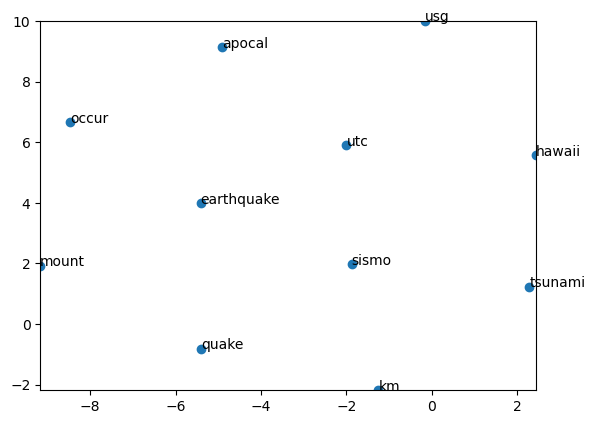

In [14]:
TSNE_10ClosestWords(cbow_model, 'earthquake', 512)

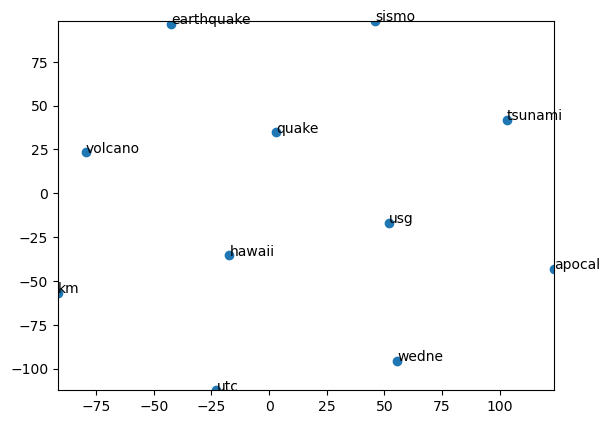

In [15]:
TSNE_10ClosestWords(skipgram_model, 'earthquake', 512)

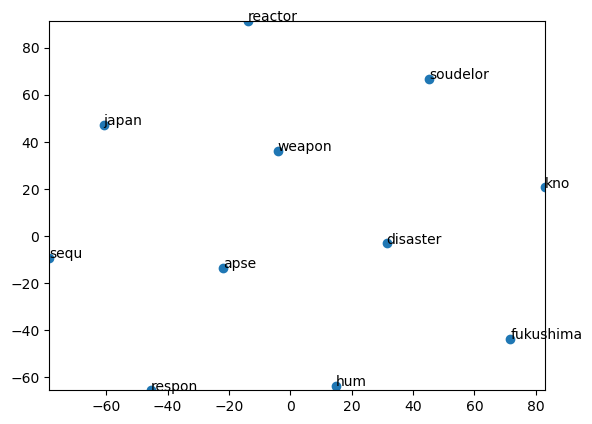

In [16]:
TSNE_10ClosestWords(cbow_model, 'disaster', 512)

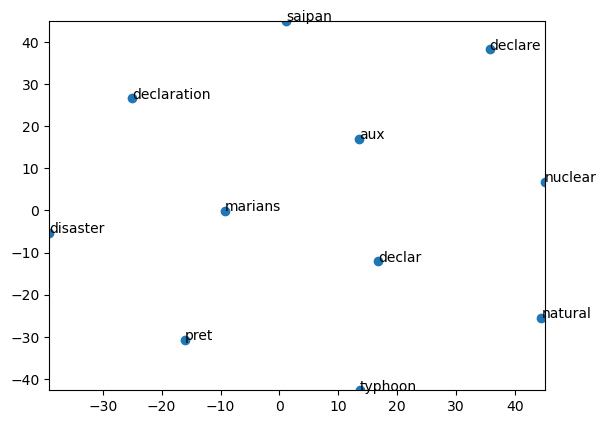

In [17]:
TSNE_10ClosestWords(skipgram_model, 'disaster', 512)

# Loading and Testing our Pre-Trained Embeddings to the PyTorch's Embedding layer

In [18]:
# create embedding layer with pre-trained weights
pretrained_embeddings_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(skipgram_model.wv.vectors))
# check weights of the pre-trained embedding layer
pretrained_embeddings_layer.weight

Parameter containing:
tensor([[ 0.0414, -0.2207,  0.1861,  ..., -0.0308,  0.0837, -0.0848],
        [-0.1327, -0.1782, -0.0074,  ...,  0.0659, -0.1683, -0.1863],
        [ 0.0210, -0.1433, -0.0212,  ..., -0.0600,  0.1392,  0.0743],
        ...,
        [ 0.0688, -0.0325, -0.1077,  ..., -0.2518,  0.0036,  0.0337],
        [ 0.0180,  0.1512, -0.3123,  ..., -0.0415, -0.1330, -0.2043],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [19]:
TrainTweetsDataset = TweetsDataset(tweets_train, 'skipgram')
TrainTweetsDataset[0]

(tensor([  31,   62,  850,  432, 2265,  425,  452, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899]),
 tensor([1.]))

In [20]:
sequence = TrainTweetsDataset[0][0]
sequence_embeddings = pretrained_embeddings_layer(sequence)

print('Embedding of the first token:          {}'.format(sequence_embeddings[0]))
print('Embedding of the second token:         {}'.format(sequence_embeddings[1]))
print('Embedding of the third token:          {}'.format(sequence_embeddings[2]))
print('Embedding of the fourth token:         {}'.format(sequence_embeddings[3]))
print('Embedding of the fifth token:          {}'.format(sequence_embeddings[4]))
print('Embedding of the sixth token:          {}'.format(sequence_embeddings[5]))
print('Embedding of the twenty-fifth token:   {}'.format(sequence_embeddings[24]))
print('Embedding of the fortieth token:       {}'.format(sequence_embeddings[39]))
print('Embedding of the fiftieth token:       {}'.format(sequence_embeddings[49]))

Embedding of the first token:          tensor([-1.4938e-01, -3.1296e-02,  3.5110e-01,  9.9947e-02,  1.1420e-01,
         2.0422e-02, -1.8522e-02, -9.7531e-02,  8.9191e-03,  1.6854e-01,
         1.4188e-01, -3.8786e-01,  3.7037e-01, -1.0994e-02,  3.5970e-02,
         1.0243e-01, -1.0458e-01, -2.9599e-01, -1.3571e-01, -2.1489e-01,
         3.6393e-01,  1.3028e-01,  1.0361e-01,  1.7510e-01, -1.2119e-01,
         3.7894e-01,  3.5232e-01,  2.6074e-01, -2.3349e-01, -1.9111e-01,
        -1.9019e-01, -5.3251e-01, -1.2993e-02, -2.1414e-01, -5.5963e-01,
         3.5878e-01, -1.2355e-01,  3.8747e-02, -1.0498e-01, -3.6733e-01,
        -8.4645e-02, -2.3541e-02, -1.6330e-01, -2.3572e-01, -1.8326e-01,
         3.1835e-01, -3.4187e-01,  1.6383e-02, -8.2616e-02,  6.3884e-02,
         1.0574e-01, -2.6724e-01,  1.8972e-01, -1.2723e-01, -6.1233e-01,
        -3.4776e-01,  1.3238e-01, -1.5830e-01,  1.0282e-01,  7.7371e-02,
         5.6541e-02,  9.2524e-02,  9.5260e-03,  1.2026e-01,  3.5963e-01,
        -2.8

# Training LSTM Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram embeddings

In [21]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 128, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 128, shuffle = False)

In [22]:
'''# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = skipgram_model,
                                  hidden_size = 64, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-2, weight_decay = 1e-5)'''

'# Initialize the network, loss function, and optimizer\ndevice = set_device()\ncustomPreTrainedLSTM = CustomLSTM(word2vec_model = skipgram_model,\n                                  hidden_size = 64, \n                                  output_size = 1, \n                                  num_layers = 1, \n                                  bidirectional = True,\n                                  freeze_embeddings = True).to(device)\n\ncriterion = torch.nn.BCEWithLogitsLoss()\noptimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-2, weight_decay = 1e-5)'

In [23]:
'''train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)'''

'train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)'

In [24]:
'''# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = skipgram_model, 
                                                      hidden_size = 64, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = False).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4, weight_decay = 1e-4)'''

'# Initialize the network, loss function, and optimizer\ndevice = set_device()\ncustomPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = skipgram_model, \n                                                      hidden_size = 64, \n                                                      output_size = 1, \n                                                      num_layers = 1, \n                                                      bidirectional = True,\n                                                      freeze_embeddings = False).to(device)\n\ncriterion = torch.nn.BCEWithLogitsLoss()\noptimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4, weight_decay = 1e-4)'

In [25]:
'''train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)'''

'train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 16, device = device)'

In [56]:
# Initialize the network, loss function, and optimizer
device = set_device()

customPreTrainedLSTM_MultiheadAttention = CustomLSTM_MultiHeadAttention(word2vec_model = skipgram_model,
                                                                        hidden_size = 512, 
                                                                        output_size = 1, 
                                                                        dropout = 0.3,
                                                                        num_layers = 3, 
                                                                        bidirectional = True,
                                                                        freeze_embeddings = True,
                                                                        num_heads = 32).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_MultiheadAttention.parameters(), lr = 1e-4)

Device: mps


In [57]:
train_losses, train_f1s, test_losses, test_f1s = train(model = customPreTrainedLSTM_MultiheadAttention, 
                                                       train_loader = TrainDataLoader_SkipGram, 
                                                       test_loader = TestDataLoader_SkipGram, 
                                                       optimizer = optimizer, 
                                                       loss_func = criterion, 
                                                       epochs = 64, 
                                                       device = device)

Epoch 1/64
======== Training phase ========


Loss = 0.5624 | Accuracy = 73.77% | F1-Score = 60.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Training Cross-Entropy Loss = 0.6985
Training Accuracy = 71.80%
Training F1-Score = 63.39%
======== Validation phase ========


Loss = 0.4775 | Accuracy = 77.78% | F1-Score = 75.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.34it/s]


Test Cross-Entropy Loss = 0.5670
Test Accuracy = 70.76%
Test F1-Score = 59.85%

Epoch 2/64
======== Training phase ========


Loss = 0.3682 | Accuracy = 85.25% | F1-Score = 78.05% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Training Cross-Entropy Loss = 0.4666
Training Accuracy = 78.44%
Training F1-Score = 70.97%
======== Validation phase ========


Loss = 0.8283 | Accuracy = 73.02% | F1-Score = 63.83% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.58it/s]


Test Cross-Entropy Loss = 1.1060
Test Accuracy = 66.47%
Test F1-Score = 38.68%

Epoch 3/64
======== Training phase ========


Loss = 0.4320 | Accuracy = 88.52% | F1-Score = 86.27% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Training Cross-Entropy Loss = 0.4341
Training Accuracy = 79.93%
Training F1-Score = 73.04%
======== Validation phase ========


Loss = 0.3611 | Accuracy = 85.71% | F1-Score = 83.64% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.55it/s]


Test Cross-Entropy Loss = 0.5205
Test Accuracy = 75.08%
Test F1-Score = 65.80%

Epoch 4/64
======== Training phase ========


Loss = 0.4379 | Accuracy = 77.05% | F1-Score = 73.08% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Training Cross-Entropy Loss = 0.3996
Training Accuracy = 82.07%
Training F1-Score = 76.23%
======== Validation phase ========


Loss = 0.9073 | Accuracy = 71.43% | F1-Score = 59.09% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.65it/s]


Test Cross-Entropy Loss = 1.2772
Test Accuracy = 64.57%
Test F1-Score = 30.02%

Epoch 5/64
======== Training phase ========


Loss = 0.4097 | Accuracy = 75.41% | F1-Score = 61.54% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Training Cross-Entropy Loss = 0.3763
Training Accuracy = 83.04%
Training F1-Score = 77.81%
======== Validation phase ========


Loss = 0.4195 | Accuracy = 84.13% | F1-Score = 83.87% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.46it/s]


Test Cross-Entropy Loss = 0.5260
Test Accuracy = 76.31%
Test F1-Score = 71.08%

Epoch 6/64
======== Training phase ========


Loss = 0.2440 | Accuracy = 90.16% | F1-Score = 85.71% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Training Cross-Entropy Loss = 0.3317
Training Accuracy = 85.42%
Training F1-Score = 81.41%
======== Validation phase ========


Loss = 0.3774 | Accuracy = 84.13% | F1-Score = 82.14% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.59it/s]


Test Cross-Entropy Loss = 0.6336
Test Accuracy = 75.64%
Test F1-Score = 65.02%

Epoch 7/64
======== Training phase ========


Loss = 0.3533 | Accuracy = 83.61% | F1-Score = 72.22% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Training Cross-Entropy Loss = 0.3135
Training Accuracy = 87.00%
Training F1-Score = 83.75%
======== Validation phase ========


Loss = 0.5292 | Accuracy = 76.19% | F1-Score = 77.61% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.46it/s]


Test Cross-Entropy Loss = 0.6661
Test Accuracy = 70.52%
Test F1-Score = 66.71%

Epoch 8/64
======== Training phase ========


Loss = 0.3126 | Accuracy = 90.16% | F1-Score = 84.21% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Training Cross-Entropy Loss = 0.2659
Training Accuracy = 89.11%
Training F1-Score = 86.49%
======== Validation phase ========


Loss = 1.1528 | Accuracy = 69.84% | F1-Score = 76.54% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.66it/s]


Test Cross-Entropy Loss = 1.4692
Test Accuracy = 58.01%
Test F1-Score = 65.75%

Epoch 9/64
======== Training phase ========


Loss = 0.2357 | Accuracy = 86.89% | F1-Score = 83.33% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Training Cross-Entropy Loss = 0.2316
Training Accuracy = 90.95%
Training F1-Score = 88.89%
======== Validation phase ========


Loss = 0.4825 | Accuracy = 79.37% | F1-Score = 77.97% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.63it/s]


Test Cross-Entropy Loss = 0.6680
Test Accuracy = 75.88%
Test F1-Score = 68.33%

Epoch 10/64
======== Training phase ========


Loss = 0.3413 | Accuracy = 91.80% | F1-Score = 87.80% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Training Cross-Entropy Loss = 0.1978
Training Accuracy = 92.83%
Training F1-Score = 91.30%
======== Validation phase ========


Loss = 0.4632 | Accuracy = 87.30% | F1-Score = 87.10% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.62it/s]


Test Cross-Entropy Loss = 0.7174
Test Accuracy = 75.82%
Test F1-Score = 70.61%

Epoch 11/64
======== Training phase ========


Loss = 0.2428 | Accuracy = 95.08% | F1-Score = 93.88% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Training Cross-Entropy Loss = 0.1719
Training Accuracy = 93.55%
Training F1-Score = 92.23%
======== Validation phase ========


Loss = 0.4933 | Accuracy = 82.54% | F1-Score = 80.70% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.54it/s]


Test Cross-Entropy Loss = 0.7661
Test Accuracy = 76.37%
Test F1-Score = 67.97%

Epoch 12/64
======== Training phase ========


Loss = 0.1828 | Accuracy = 91.80% | F1-Score = 88.37% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]  


Training Cross-Entropy Loss = 0.1400
Training Accuracy = 95.02%
Training F1-Score = 94.04%
======== Validation phase ========


Loss = 0.5994 | Accuracy = 82.54% | F1-Score = 81.36% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.57it/s]


Test Cross-Entropy Loss = 0.9739
Test Accuracy = 74.20%
Test F1-Score = 65.12%

Epoch 13/64
======== Training phase ========


Loss = 0.1083 | Accuracy = 95.08% | F1-Score = 94.34% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Training Cross-Entropy Loss = 0.1353
Training Accuracy = 95.26%
Training F1-Score = 94.35%
======== Validation phase ========


Loss = 0.7543 | Accuracy = 76.19% | F1-Score = 79.45% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.53it/s]


Test Cross-Entropy Loss = 1.2962
Test Accuracy = 66.41%
Test F1-Score = 68.65%

Epoch 14/64
======== Training phase ========


Loss = 0.0752 | Accuracy = 98.36% | F1-Score = 98.11% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Training Cross-Entropy Loss = 0.1154
Training Accuracy = 95.93%
Training F1-Score = 95.17%
======== Validation phase ========


Loss = 0.5657 | Accuracy = 84.13% | F1-Score = 83.87% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.59it/s]


Test Cross-Entropy Loss = 0.8379
Test Accuracy = 73.43%
Test F1-Score = 69.89%

Epoch 15/64
======== Training phase ========


Loss = 0.2908 | Accuracy = 90.16% | F1-Score = 88.46% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]  


Training Cross-Entropy Loss = 0.1114
Training Accuracy = 96.30%
Training F1-Score = 95.62%
======== Validation phase ========


Loss = 0.4305 | Accuracy = 85.71% | F1-Score = 86.15% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.61it/s]


Test Cross-Entropy Loss = 0.8328
Test Accuracy = 75.11%
Test F1-Score = 69.10%

Epoch 16/64
======== Training phase ========


Loss = 0.0701 | Accuracy = 98.36% | F1-Score = 97.96% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]  


Training Cross-Entropy Loss = 0.0933
Training Accuracy = 96.73%
Training F1-Score = 96.14%
======== Validation phase ========


Loss = 0.6089 | Accuracy = 80.95% | F1-Score = 82.86% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.53it/s]


Test Cross-Entropy Loss = 1.2021
Test Accuracy = 69.26%
Test F1-Score = 69.50%

Epoch 17/64
======== Training phase ========


Loss = 0.0732 | Accuracy = 96.72% | F1-Score = 95.83% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Training Cross-Entropy Loss = 0.0872
Training Accuracy = 96.97%
Training F1-Score = 96.43%
======== Validation phase ========


Loss = 0.5130 | Accuracy = 84.13% | F1-Score = 82.14% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.56it/s]


Test Cross-Entropy Loss = 0.9023
Test Accuracy = 75.64%
Test F1-Score = 66.92%

Epoch 18/64
======== Training phase ========


Loss = 0.0175 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Training Cross-Entropy Loss = 0.0809
Training Accuracy = 96.93%
Training F1-Score = 96.37%
======== Validation phase ========


Loss = 0.4539 | Accuracy = 90.48% | F1-Score = 90.32% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.58it/s]


Test Cross-Entropy Loss = 0.9198
Test Accuracy = 75.64%
Test F1-Score = 69.94%

Epoch 19/64
======== Training phase ========


Loss = 0.0238 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Training Cross-Entropy Loss = 0.0754
Training Accuracy = 97.54%
Training F1-Score = 97.11%
======== Validation phase ========


Loss = 0.6550 | Accuracy = 85.71% | F1-Score = 85.25% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.52it/s]


Test Cross-Entropy Loss = 1.0661
Test Accuracy = 75.64%
Test F1-Score = 69.51%

Epoch 20/64
======== Training phase ========


Loss = 0.0936 | Accuracy = 96.72% | F1-Score = 96.15% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]  


Training Cross-Entropy Loss = 0.0752
Training Accuracy = 97.48%
Training F1-Score = 97.02%
======== Validation phase ========


Loss = 0.4276 | Accuracy = 85.71% | F1-Score = 85.25% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.54it/s]


Test Cross-Entropy Loss = 0.9331
Test Accuracy = 75.57%
Test F1-Score = 70.67%

Epoch 21/64
======== Training phase ========


Loss = 0.0791 | Accuracy = 98.36% | F1-Score = 98.04% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]  


Training Cross-Entropy Loss = 0.0690
Training Accuracy = 97.52%
Training F1-Score = 97.09%
======== Validation phase ========


Loss = 0.3776 | Accuracy = 87.30% | F1-Score = 85.71% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.64it/s]


Test Cross-Entropy Loss = 0.9045
Test Accuracy = 77.17%
Test F1-Score = 69.63%

Epoch 22/64
======== Training phase ========


Loss = 0.1595 | Accuracy = 95.08% | F1-Score = 92.68% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]  


Training Cross-Entropy Loss = 0.0679
Training Accuracy = 97.68%
Training F1-Score = 97.27%
======== Validation phase ========


Loss = 0.4727 | Accuracy = 84.13% | F1-Score = 84.85% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.65it/s]


Test Cross-Entropy Loss = 0.9727
Test Accuracy = 73.61%
Test F1-Score = 70.16%

Epoch 23/64
======== Training phase ========


Loss = 0.0568 | Accuracy = 98.36% | F1-Score = 98.04% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]  


Training Cross-Entropy Loss = 0.0715
Training Accuracy = 97.35%
Training F1-Score = 96.87%
======== Validation phase ========


Loss = 0.6123 | Accuracy = 84.13% | F1-Score = 82.76% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.59it/s]


Test Cross-Entropy Loss = 1.0172
Test Accuracy = 76.77%
Test F1-Score = 68.86%

Epoch 24/64
======== Training phase ========


Loss = 0.0833 | Accuracy = 95.08% | F1-Score = 93.02% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]  


Training Cross-Entropy Loss = 0.0572
Training Accuracy = 97.89%
Training F1-Score = 97.52%
======== Validation phase ========


Loss = 0.5123 | Accuracy = 82.54% | F1-Score = 81.97% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.48it/s]


Test Cross-Entropy Loss = 0.8611
Test Accuracy = 75.67%
Test F1-Score = 69.51%

Epoch 25/64
======== Training phase ========


Loss = 0.0060 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Training Cross-Entropy Loss = 0.0581
Training Accuracy = 97.83%
Training F1-Score = 97.45%
======== Validation phase ========


Loss = 0.5688 | Accuracy = 84.13% | F1-Score = 82.76% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Test Cross-Entropy Loss = 1.2058
Test Accuracy = 75.48%
Test F1-Score = 67.13%

Epoch 26/64
======== Training phase ========


Loss = 0.0273 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Training Cross-Entropy Loss = 0.0547
Training Accuracy = 97.87%
Training F1-Score = 97.50%
======== Validation phase ========


Loss = 0.5981 | Accuracy = 85.71% | F1-Score = 84.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.54it/s]


Test Cross-Entropy Loss = 1.1294
Test Accuracy = 75.39%
Test F1-Score = 68.69%

Epoch 27/64
======== Training phase ========


Loss = 0.0997 | Accuracy = 95.08% | F1-Score = 94.12% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]  


Training Cross-Entropy Loss = 0.0597
Training Accuracy = 97.70%
Training F1-Score = 97.29%
======== Validation phase ========


Loss = 0.5586 | Accuracy = 84.13% | F1-Score = 84.85% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Test Cross-Entropy Loss = 1.1134
Test Accuracy = 73.64%
Test F1-Score = 70.77%

Epoch 28/64
======== Training phase ========


Loss = 0.0262 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Training Cross-Entropy Loss = 0.0611
Training Accuracy = 97.66%
Training F1-Score = 97.25%
======== Validation phase ========


Loss = 0.5414 | Accuracy = 87.30% | F1-Score = 85.71% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.56it/s]


Test Cross-Entropy Loss = 0.9450
Test Accuracy = 75.85%
Test F1-Score = 65.86%

Epoch 29/64
======== Training phase ========


Loss = 0.0424 | Accuracy = 98.36% | F1-Score = 97.78% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]  


Training Cross-Entropy Loss = 0.0618
Training Accuracy = 97.71%
Training F1-Score = 97.31%
======== Validation phase ========


Loss = 0.4516 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.59it/s]


Test Cross-Entropy Loss = 1.0469
Test Accuracy = 77.32%
Test F1-Score = 71.36%

Epoch 30/64
======== Training phase ========


Loss = 0.1100 | Accuracy = 95.08% | F1-Score = 94.55% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]  


Training Cross-Entropy Loss = 0.0552
Training Accuracy = 97.87%
Training F1-Score = 97.50%
======== Validation phase ========


Loss = 0.4598 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.58it/s]


Test Cross-Entropy Loss = 0.9010
Test Accuracy = 75.15%
Test F1-Score = 68.75%

Epoch 31/64
======== Training phase ========


Loss = 0.2348 | Accuracy = 95.08% | F1-Score = 95.38% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]  


Training Cross-Entropy Loss = 0.0730
Training Accuracy = 97.50%
Training F1-Score = 97.07%
======== Validation phase ========


Loss = 0.3804 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.54it/s]


Test Cross-Entropy Loss = 1.0632
Test Accuracy = 75.30%
Test F1-Score = 69.54%

Epoch 32/64
======== Training phase ========


Loss = 0.0175 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Training Cross-Entropy Loss = 0.0538
Training Accuracy = 97.87%
Training F1-Score = 97.51%
======== Validation phase ========


Loss = 0.4633 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.56it/s]


Test Cross-Entropy Loss = 1.0419
Test Accuracy = 74.72%
Test F1-Score = 68.69%

Epoch 33/64
======== Training phase ========


Loss = 0.0194 | Accuracy = 98.36% | F1-Score = 98.46% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]  


Training Cross-Entropy Loss = 0.0491
Training Accuracy = 98.02%
Training F1-Score = 97.67%
======== Validation phase ========


Loss = 0.4925 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.49it/s]


Test Cross-Entropy Loss = 1.1047
Test Accuracy = 76.62%
Test F1-Score = 70.35%

Epoch 34/64
======== Training phase ========


Loss = 0.0176 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Training Cross-Entropy Loss = 0.0464
Training Accuracy = 98.10%
Training F1-Score = 97.76%
======== Validation phase ========


Loss = 0.8141 | Accuracy = 85.71% | F1-Score = 84.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Test Cross-Entropy Loss = 1.3463
Test Accuracy = 75.97%
Test F1-Score = 66.52%

Epoch 35/64
======== Training phase ========


Loss = 0.0647 | Accuracy = 96.72% | F1-Score = 95.83% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]  


Training Cross-Entropy Loss = 0.0470
Training Accuracy = 98.00%
Training F1-Score = 97.65%
======== Validation phase ========


Loss = 0.5026 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.47it/s]


Test Cross-Entropy Loss = 1.2097
Test Accuracy = 73.58%
Test F1-Score = 70.03%

Epoch 36/64
======== Training phase ========


Loss = 0.1035 | Accuracy = 96.72% | F1-Score = 95.45% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]  


Training Cross-Entropy Loss = 0.0516
Training Accuracy = 97.87%
Training F1-Score = 97.50%
======== Validation phase ========


Loss = 0.6675 | Accuracy = 85.71% | F1-Score = 85.71% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.61it/s]


Test Cross-Entropy Loss = 1.2931
Test Accuracy = 73.95%
Test F1-Score = 70.71%

Epoch 37/64
======== Training phase ========


Loss = 0.0598 | Accuracy = 98.36% | F1-Score = 97.96% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]  


Training Cross-Entropy Loss = 0.0428
Training Accuracy = 98.20%
Training F1-Score = 97.88%
======== Validation phase ========


Loss = 0.8586 | Accuracy = 82.54% | F1-Score = 83.58% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.61it/s]


Test Cross-Entropy Loss = 1.5763
Test Accuracy = 71.84%
Test F1-Score = 70.38%

Epoch 38/64
======== Training phase ========


Loss = 0.0809 | Accuracy = 95.08% | F1-Score = 93.88% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]  


Training Cross-Entropy Loss = 0.0539
Training Accuracy = 97.71%
Training F1-Score = 97.31%
======== Validation phase ========


Loss = 0.7370 | Accuracy = 85.71% | F1-Score = 85.25% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Test Cross-Entropy Loss = 1.2250
Test Accuracy = 75.79%
Test F1-Score = 69.62%

Epoch 39/64
======== Training phase ========


Loss = 0.0957 | Accuracy = 96.72% | F1-Score = 94.74% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]  


Training Cross-Entropy Loss = 0.0528
Training Accuracy = 97.82%
Training F1-Score = 97.44%
======== Validation phase ========


Loss = 0.6494 | Accuracy = 87.30% | F1-Score = 87.50% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.63it/s]


Test Cross-Entropy Loss = 1.2974
Test Accuracy = 74.16%
Test F1-Score = 69.75%

Epoch 40/64
======== Training phase ========


Loss = 0.0799 | Accuracy = 96.72% | F1-Score = 95.83% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]  


Training Cross-Entropy Loss = 0.0510
Training Accuracy = 97.86%
Training F1-Score = 97.48%
======== Validation phase ========


Loss = 0.5965 | Accuracy = 84.13% | F1-Score = 83.87% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.50it/s]


Test Cross-Entropy Loss = 1.1839
Test Accuracy = 74.69%
Test F1-Score = 70.37%

Epoch 41/64
======== Training phase ========


Loss = 0.1038 | Accuracy = 96.72% | F1-Score = 95.65% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]  


Training Cross-Entropy Loss = 0.0411
Training Accuracy = 98.29%
Training F1-Score = 97.99%
======== Validation phase ========


Loss = 0.5115 | Accuracy = 84.13% | F1-Score = 82.14% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.52it/s]


Test Cross-Entropy Loss = 1.1272
Test Accuracy = 76.25%
Test F1-Score = 67.86%

Epoch 42/64
======== Training phase ========


Loss = 0.0384 | Accuracy = 98.36% | F1-Score = 97.67% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]  


Training Cross-Entropy Loss = 0.0577
Training Accuracy = 97.56%
Training F1-Score = 97.12%
======== Validation phase ========


Loss = 0.5031 | Accuracy = 90.48% | F1-Score = 90.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.59it/s]


Test Cross-Entropy Loss = 1.1245
Test Accuracy = 75.36%
Test F1-Score = 70.16%

Epoch 43/64
======== Training phase ========


Loss = 0.0773 | Accuracy = 98.36% | F1-Score = 97.96% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]  


Training Cross-Entropy Loss = 0.0439
Training Accuracy = 98.15%
Training F1-Score = 97.82%
======== Validation phase ========


Loss = 0.5429 | Accuracy = 87.30% | F1-Score = 87.50% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Test Cross-Entropy Loss = 1.2219
Test Accuracy = 72.11%
Test F1-Score = 70.30%

Epoch 44/64
======== Training phase ========


Loss = 0.0298 | Accuracy = 100.00% | F1-Score = 100.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Training Cross-Entropy Loss = 0.0447
Training Accuracy = 97.94%
Training F1-Score = 97.57%
======== Validation phase ========


Loss = 0.5473 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.57it/s]


Test Cross-Entropy Loss = 1.0512
Test Accuracy = 74.84%
Test F1-Score = 70.29%

Epoch 45/64
======== Training phase ========


Loss = 0.0370 | Accuracy = 98.36% | F1-Score = 98.18% | Batch ID = 60 : 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]  


Training Cross-Entropy Loss = 0.0426
Training Accuracy = 98.16%
Training F1-Score = 97.84%
======== Validation phase ========


Loss = 0.4625 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:02<00:00, 10.54it/s]


Test Cross-Entropy Loss = 1.3284
Test Accuracy = 74.38%
Test F1-Score = 68.81%

Epoch 46/64
======== Training phase ========


Loss = 0.0348 | Accuracy = 97.66% | F1-Score = 97.48% | Batch ID = 44 :  73%|███████▎  | 44/60 [00:10<00:03,  4.27it/s]  


KeyboardInterrupt: 

In [ ]:
pbar = tqdm(enumerate(TrainDataLoader_SkipGram), total=len(TrainDataLoader_SkipGram))
bidirectional = True
hidden_size = 128
num_heads = 8

for batch_idx, (data, target) in pbar:
    data = data
    target = target

    x = torch.nn.Embedding.from_pretrained(torch.FloatTensor(skipgram_model.wv.vectors), freeze = True)(data)
    output, _ = torch.nn.LSTM(skipgram_model.vector_size, hidden_size, 1, batch_first = True, bidirectional = bidirectional)(x)
    attn_output, attn_weights = torch.nn.MultiheadAttention(embed_dim = hidden_size * (2 if bidirectional else 1), num_heads = num_heads, batch_first = True)(output, output, output)

    # Flatten the multihead attention outputs across the sequence dimension to go from a shape (batch_size, seq_len, embedding_dim) to (batch_size, seq_len * embedding_dim)
    flattened_output = attn_output.reshape(attn_output.size(0), -1)

    logits = torch.nn.Linear(flattened_output.size(1), 1)(flattened_output)

    break

## CBOW embeddings

In [ ]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 128, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 128, shuffle = False)

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = cbow_model,
                                  hidden_size = 256, 
                                  output_size = 1, 
                                  num_layers = 3, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6731 | Accuracy = 62.30% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.18it/s]


Training Cross-Entropy Loss = 0.6861
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6969 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.93it/s]


Test Cross-Entropy Loss = 0.6842
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6877 | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.40it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7035 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.13it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.7004 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.44it/s]


Training Cross-Entropy Loss = 0.6836
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7000 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.29it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6784 | Accuracy = 59.02% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.35it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6990 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.19it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.7045 | Accuracy = 49.18% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.43it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6991 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.94it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6866 | Accuracy = 55.74% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.40it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6983 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.20it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.6823 | Accuracy = 57.38% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.31it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7006 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.37it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6998 | Accuracy = 50.82% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.38it/s]


Training Cross-Entropy Loss = 0.6836
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.6996 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.90it/s]

Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = cbow_model, 
                                                      hidden_size = 256, 
                                                      output_size = 1, 
                                                      num_layers = 3, 
                                                      bidirectional = True,
                                                      freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.4845 | Accuracy = 77.05% | F1-Score = 58.82% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.16it/s]


Training Cross-Entropy Loss = 0.6515
Training Accuracy = 58.33%
Training F1-Score = 6.43%
======== Validation phase ========


Loss = 0.4120 | Accuracy = 84.13% | F1-Score = 80.77% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.10it/s]


Test Cross-Entropy Loss = 0.5274
Test Accuracy = 73.83%
Test F1-Score = 61.00%

Epoch 2/8
======== Training phase ========


Loss = 0.5151 | Accuracy = 72.13% | F1-Score = 63.83% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.11it/s]


Training Cross-Entropy Loss = 0.4761
Training Accuracy = 77.49%
Training F1-Score = 69.17%
======== Validation phase ========


Loss = 0.3149 | Accuracy = 88.89% | F1-Score = 87.72% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.05it/s]


Test Cross-Entropy Loss = 0.4681
Test Accuracy = 77.63%
Test F1-Score = 68.45%

Epoch 3/8
======== Training phase ========


Loss = 0.5320 | Accuracy = 75.41% | F1-Score = 63.41% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.17it/s]


Training Cross-Entropy Loss = 0.4355
Training Accuracy = 79.99%
Training F1-Score = 72.83%
======== Validation phase ========


Loss = 0.3117 | Accuracy = 90.48% | F1-Score = 89.66% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.04it/s]


Test Cross-Entropy Loss = 0.4572
Test Accuracy = 77.47%
Test F1-Score = 67.61%

Epoch 4/8
======== Training phase ========


Loss = 0.2277 | Accuracy = 93.44% | F1-Score = 92.31% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.11it/s]


Training Cross-Entropy Loss = 0.4039
Training Accuracy = 82.08%
Training F1-Score = 76.10%
======== Validation phase ========


Loss = 0.3188 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.06it/s]


Test Cross-Entropy Loss = 0.4546
Test Accuracy = 78.46%
Test F1-Score = 70.12%

Epoch 5/8
======== Training phase ========


Loss = 0.4525 | Accuracy = 78.69% | F1-Score = 60.61% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.16it/s]


Training Cross-Entropy Loss = 0.3801
Training Accuracy = 83.59%
Training F1-Score = 78.33%
======== Validation phase ========


Loss = 0.3313 | Accuracy = 88.89% | F1-Score = 88.14% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.05it/s]


Test Cross-Entropy Loss = 0.4599
Test Accuracy = 78.88%
Test F1-Score = 71.66%

Epoch 6/8
======== Training phase ========


Loss = 0.2912 | Accuracy = 88.52% | F1-Score = 86.79% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.11it/s]


Training Cross-Entropy Loss = 0.3468
Training Accuracy = 84.91%
Training F1-Score = 80.13%
======== Validation phase ========


Loss = 0.3818 | Accuracy = 87.30% | F1-Score = 86.67% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.16it/s]


Test Cross-Entropy Loss = 0.4954
Test Accuracy = 79.04%
Test F1-Score = 73.34%

Epoch 7/8
======== Training phase ========


Loss = 0.3543 | Accuracy = 86.89% | F1-Score = 80.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.18it/s]


Training Cross-Entropy Loss = 0.3137
Training Accuracy = 86.96%
Training F1-Score = 83.31%
======== Validation phase ========


Loss = 0.3736 | Accuracy = 85.71% | F1-Score = 84.75% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 40.52it/s]


Test Cross-Entropy Loss = 0.5078
Test Accuracy = 77.93%
Test F1-Score = 71.22%

Epoch 8/8
======== Training phase ========


Loss = 0.2430 | Accuracy = 91.80% | F1-Score = 91.80% | Batch ID = 60 : 100%|██████████| 60/60 [00:03<00:00, 16.15it/s]


Training Cross-Entropy Loss = 0.2741
Training Accuracy = 89.26%
Training F1-Score = 86.39%
======== Validation phase ========


Loss = 0.3686 | Accuracy = 87.30% | F1-Score = 86.21% | Batch ID = 26 : 100%|██████████| 26/26 [00:00<00:00, 41.08it/s]

Test Cross-Entropy Loss = 0.5246
Test Accuracy = 78.21%
Test F1-Score = 71.46%



# Training GRU Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram Embeddings

In [ ]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 128, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 128, shuffle = False)

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = skipgram_model, 
                                hidden_size = 256, 
                                output_size = 1, 
                                num_layers = 3, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6638 | Accuracy = 63.93% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


Training Cross-Entropy Loss = 0.6843
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7076 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


Test Cross-Entropy Loss = 0.6849
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6979 | Accuracy = 52.46% | F1-Score = 0.00% | Batch ID = 60 : 100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


Training Cross-Entropy Loss = 0.6845
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7045 | Accuracy = 50.79% | F1-Score = 0.00% | Batch ID = 26 : 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Test Cross-Entropy Loss = 0.6840
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6854 | Accuracy = 58.59% | F1-Score = 0.00% | Batch ID = 17 :  28%|██▊       | 17/60 [00:11<00:29,  1.44it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = skipgram_model, 
                                                    hidden_size = 256, 
                                                    output_size = 1, 
                                                    num_layers = 3, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.5972 | Accuracy = 66.14% | F1-Score = 39.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Training Cross-Entropy Loss = 0.6553
Training Accuracy = 58.26%
Training F1-Score = 5.59%
======== Validation phase ========


Loss = 0.5561 | Accuracy = 67.54% | F1-Score = 56.34% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 65.22%
Test F1-Score = 33.97%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 55.03% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.61it/s]  


Training Cross-Entropy Loss = nan
Training Accuracy = 58.30%
Training F1-Score = 5.81%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.92it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 54.50% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.46it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.95it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.61it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.97it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 47.62% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.64it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 60.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.71it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 54.50% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.90it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## CBOW Embeddings

In [ ]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 128, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 128, shuffle = False)

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = cbow_model, 
                                hidden_size = 256, 
                                output_size = 1, 
                                num_layers = 3, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 57.67% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.44it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.88it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.41it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 63.49% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.14it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 60.32% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.34it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 61.90% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.25it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 55.56% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.74it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = cbow_model, 
                                                    hidden_size = 256, 
                                                    output_size = 1, 
                                                    num_layers = 3, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 1e-4, weight_decay = 1e-5)

Device: mps


In [ ]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 58.20% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 58.73% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.91it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.45it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 52.38% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.08it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 55.56% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.93it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 62.96% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.53it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.63it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.34it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

